<h1><b>Задача по предсказанию рейтинга шоколада

<h3><b>Никнейм на Kaggle: 

# Описание задачи

In [1]:
# Даны характеристики шоколадок и по ним нужно предсказать их рейтинг.

# Описание данных
# Company - компания производитель
# Specific Bean Origin - географический регион происхождения
# REF - параметр, определяющий момент внесения записи в базу данных (чем выше значение, тем "свежее" запись)
# Review - дата публикации отзыва
# Cocoa Percent - процентное содержание какао
# Company Location - страна производитель
# Rating - экспертный рейтинг
# Bean Type - используемый сорт какао-бобов, если таковой имеется
# Broad Bean Origin - географический регион происхождения какао-бобов

# Файлы с данными
# choco_train.csv - тренировочные данные
# choco_test_new.csv - тестовые данные
# choco_sample_submission.csv - пример submission

# Импорт библиотек, константы

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRanker, LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
import optuna

In [6]:
import association_metrics as am
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_percentage_error as MAPE, mean_absolute_error as MAE, r2_score, mean_squared_error as MSE
from scipy import stats

from sklearn.pipeline import Pipeline

In [7]:
RANDOM_STATE = 42

<!-- # Загрузка данных -->

# Загрузка данных

In [8]:
# TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
# TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"
TRAIN = 'data\chocolate-rating\chocolate_train.csv'
TEST = 'data\chocolate-rating\chocolate_test_new.csv'

In [9]:
train_df = pd.read_csv(TRAIN)

In [10]:
test_df = pd.read_csv(TEST)

In [11]:
train_df['Bean Type'].value_counts().index[0]

'\xa0'

In [12]:
train_df = train_df.replace('\xa0', np.NaN)
test_df = test_df.replace('\xa0', np.NaN)

# Обзор данных

Описание данных
* Company - компания производитель
* Specific Bean Origin - географический регион происхождения
* REF - параметр, определяющий момент внесения записи в базу данных (чем выше значение, тем "свежее" запись)
* Review - дата публикации отзыва
* Cocoa Percent - процентное содержание какао
* Company Location - страна производитель
* Rating - экспертный рейтинг
* Bean Type - используемый сорт какао-бобов, если таковой имеется
* Broad Bean Origin - географический регион происхождения какао-бобов

In [13]:
test_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Ohiyo,"San Juan Estate, Gran Couva",1594,2015,70%,U.S.A.,Trinitario,Trinidad
1,Blanxart,Organic Dark,322,2009,72%,Spain,NaN,NaN
2,Brazen,Maya Mountain,1518,2015,80%,U.S.A.,Trinitario,Belize
3,Patric,Madagascar,439,2009,67%,U.S.A.,Trinitario,Madagascar
4,Potomac,"Upala, Batch 12",607,2010,82%,U.S.A.,Matina,Costa Rica


In [14]:
test_df.nunique()

Company                 244
Specific Bean Origin    385
REF                     338
Review                   12
Cocoa Percent            38
Company Location         42
Bean Type                19
Broad Bean Origin        59
dtype: int64

In [15]:
test_df.nunique()

Company                 244
Specific Bean Origin    385
REF                     338
Review                   12
Cocoa Percent            38
Company Location         42
Bean Type                19
Broad Bean Origin        59
dtype: int64

In [16]:
# Словарь маппинга для разновидностей какао сорта
cacao_map = {
    'Amazonian': ['Amazon', 'Amazon mix', 'Amazon, ICS'],
    'Beniano': ['Beniano'],
    'Blend': ['Blend', 'Blend-Forastero,Criollo', 'Criollo, Forastero', 'Criollo, Trinitario',
    'Forastero, Trinitario', 'Trinitario, Criollo', 'Trinitario, Forastero', 'Trinitario, Nacional',
    'Trinitario, TCGA'],
    'CCN51': ['CCN51'],
    'Criollo': ['Criollo', 'Criollo (Amarru)', 'Criollo (Ocumare 61)', 'Criollo (Ocumare 67)',
    'Criollo (Ocumare 77)', 'Criollo (Ocumare)', 'Criollo (Porcelana)', 'Criollo (Wild)',
    'Criollo, +'],
    'EET': ['EET'],
    'Forastero': ['Forastero', 'Forastero (Amelonado)', 'Forastero (Arriba)', 'Forastero (Arriba) ASS',
    'Forastero (Arriba) ASSS', 'Forastero (Catongo)', 'Forastero (Nacional)', 'Forastero (Parazinho)',
    'Forastero(Arriba, CCN)'],
    'Matina': ['Matina'],
    'Nacional': ['Nacional', 'Nacional (Arriba)'],
    'Trinitario': ['Trinitario', 'Trinitario (85% Criollo)', 'Trinitario (Amelonado)', 'Trinitario (Scavina)']
}

# Функция для маппинга типов какао
def map_cacao_type(value):
    for category, variants in cacao_map.items():
        if value in variants:
            return category
    return value

In [17]:
train_df['Bean Type'] = train_df['Bean Type'].apply(map_cacao_type)
test_df['Bean Type'] = test_df['Bean Type'].apply(map_cacao_type)

In [18]:
# Словарь соответствий (дочерние -> основное). Названия регионов
region_mapping = {'Australia': ['Australia'],
 'Belize': ['Belize'],
 'Bolivia': ['Bolivia'],
 'Brazil': ['Brazil'],
 'Burma': ['Burma'],
 'Cameroon': ['Cameroon'],
 'Carribean': ['Carribean', 'Carribean(DR/Jam/Tri)', 'Africa, Carribean, C. Am.'],
 'Colombia': ['Colombia', 'Colombia, Ecuador'],
 'Congo': ['Congo'],
 'Costa Rica': ['Costa Rica', 'Cost Rica, Ven'],
 'Cuba': ['Cuba'],
 'Dominican Republic': ['Dominican Republic', 'DR, Ecuador, Peru', 'Dom. Rep., Madagascar', 'Domincan Republic', 'Dominican Rep., Bali'],
 'Ecuador': ['Ecuador', 'Ecuador, Costa Rica', 'Ecuador, Mad., PNG'],
 'El Salvador': ['El Salvador'],
 'Fiji': ['Fiji'],
 'Gabon': ['Gabon'],
 'Ghana': ['Ghana', 'Ghana & Madagascar', 'Ghana, Domin. Rep', 'Ghana, Panama, Ecuador'],
 'Grenada': ['Grenada', 'Gre., PNG, Haw., Haiti, Mad'],
 'Guatemala': ['Guatemala', 'Guat., D.R., Peru, Mad., PNG',],
 'Haiti': ['Haiti'],
 'Hawaii': ['Hawaii'],
 'Honduras': ['Honduras'],
 'India': ['India'],
 'Indonesia': ['Indonesia', 'Indonesia, Ghana'],
 'Ivory Coast': ['Ivory Coast'],
 'Jamaica': ['Jamaica'],
 'Liberia': ['Liberia'],
 'Madagascar': ['Madagascar', 'Madagascar & Ecuador','Mad., Java, PNG'],
 'Malaysia': ['Malaysia'],
 'Martinique': ['Martinique'],
 'Mexico': ['Mexico'],
 'Nicaragua': ['Nicaragua'],
 'Nigeria': ['Nigeria'],
 'Panama': ['Panama'],
 'Papua New Guinea': ['Papua New Guinea', 'PNG, Vanuatu, Mad'],
 'Peru': ['Peru', 'Peru(SMartin,Pangoa,nacional)', 'Peru, Belize', 'Peru, Dom. Rep', 'Peru, Ecuador',
 'Peru, Ecuador, Venezuela', 'Peru, Mad., Dom. Rep.', 'Peru, Madagascar'],
 'Philippines': ['Philippines'],
 'Principe': ['Principe'],
 'Puerto Rico': ['Puerto Rico'],
 'Samoa': ['Samoa'],
 'Sao Tome': ['Sao Tome', 'Sao Tome & Principe'],
 'Solomon Islands': ['Solomon Islands'],
 'South America': ['South America', 'South America, Africa', 'Central and S. America'],
 'Sri Lanka': ['Sri Lanka'],
 'St. Lucia': ['St. Lucia'],
 'Suriname': ['Suriname'],
 'Tanzania': ['Tanzania'],
 'Tobago': ['Tobago'],
 'Togo': ['Togo'],
 'Trinidad': ['Trinidad', 'Trinidad, Ecuador', 'Trinidad, Tobago', 'Trinidad-Tobago',],
 'Uganda': ['Uganda'],
 'Vanuatu': ['Vanuatu'],
'Venezuela': ['Venezuela', 'Ven, Bolivia, D.R.', 'Ven, Trinidad, Ecuador', 'Ven., Indonesia, Ecuad.',
 'Ven., Trinidad, Mad.', 'Ven.,Ecu.,Peru,Nic.', 'Venez,Africa,Brasil,Peru,Mex',
 'Venezuela, Carribean', 'Venezuela, Dom. Rep.', 'Venezuela, Ghana', 'Venezuela, Java',
 'Venezuela, Trinidad', 'Venezuela/ Ghana'],
 'Vietnam': ['Vietnam'],
 'West Africa': ['West Africa']
}

# Функция для замены названий
def standardize_region(region):
    for main_region, aliases in region_mapping.items():
        if region in aliases:
            return main_region
    return region # Если нет в словаре, оставить как есть

In [19]:
train_df['Broad Bean Origin'] = train_df['Broad Bean Origin'].apply(standardize_region)
test_df['Broad Bean Origin'] = test_df['Broad Bean Origin'].apply(standardize_region)

In [20]:
df_concat = pd.concat([train_df, test_df], axis=0)

In [21]:
cols_temp = ['Company', 'Specific Bean Origin',
       'Company Location', 'Bean Type', 'Broad Bean Origin']

In [22]:
cols_temp

['Company',
 'Specific Bean Origin',
 'Company Location',
 'Bean Type',
 'Broad Bean Origin']

In [23]:
df_concat

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,NaN,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,NaN,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia
...,...,...,...,...,...,...,...,...,...
535,Monsieur Truffe,Papaua New Guinea,1391,2014,70%,Australia,NaN,NaN,Papua New Guinea
536,Cacao Hunters,Macondo,1816,2016,71%,Colombia,NaN,NaN,Colombia
537,Bonnat,Maragnam,1038,2013,75%,France,NaN,NaN,Brazil
538,Altus aka Cao Artisan,Acopagro,1728,2016,60%,U.S.A.,NaN,NaN,Peru


In [24]:
from association_metrics import CramersV

cramer_df = df_concat[cols_temp]
cramer_df = cramer_df.astype('category')

cramer = CramersV(cramer_df)
cramer = cramer.fit()

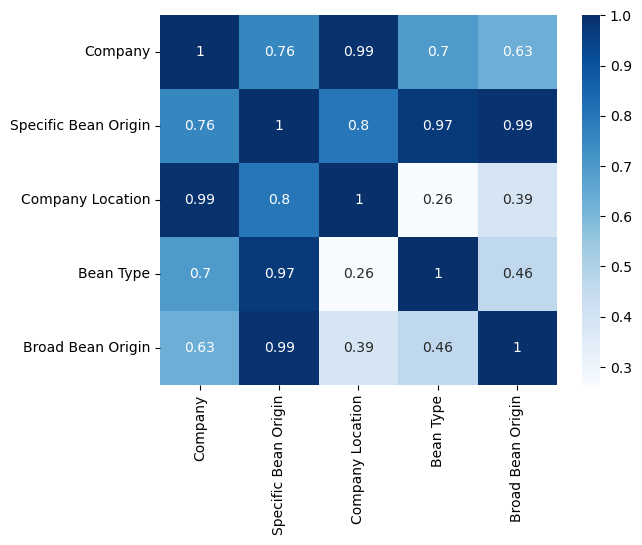

In [25]:
import seaborn as sns

sns.heatmap(cramer, cmap='Blues', annot=True);

In [26]:
def select_top3_corr_cols(col_in):
    select_df = cramer[col_in].sort_values(ascending=False)
    return select_df[1:].index.to_list()

In [27]:
def get_temp_df(col_in, col_on):
    temp_df = df_concat.groupby(col_on)[col_in] \
                        .agg(lambda x: np.random.choice(x.mode()) if len(x.mode()) > 0 else np.NaN) \
                        .dropna().reset_index()
    return temp_df

In [28]:
def fill_rows(row, col_on, temp_df):
    for variants, category in temp_df.values:
        if row[col_on] == variants:
            return category
    return np.NaN

In [29]:
train_df.isna().sum()

Company                   0
Specific Bean Origin      0
REF                       0
Review                    0
Cocoa Percent             0
Company Location          0
Rating                    0
Bean Type               629
Broad Bean Origin        56
dtype: int64

In [30]:
def prepared_df(df, col_in):
    selected_cols = select_top3_corr_cols(col_in)
    print(selected_cols)
    for col_on in selected_cols:
        temp_df = get_temp_df(col_in, col_on)
        df[col_in] = df.apply(lambda row: fill_rows(row, col_on, temp_df) if row[col_in] is np.NaN else row[col_in], axis=1)
        df[col_in] = df[col_in].fillna('Other')

In [31]:
# cols_in = ['Bean Type', 'Broad Bean Origin']

# for col_in in cols_in:
#     prepared_df(train_df, col_in)

# for col_in in cols_in:
#     prepared_df(test_df, col_in)

In [32]:
train_df = train_df.replace('\xa0', np.NaN)
train_df['Review'] = train_df['Review'].astype('object')

test_df = test_df.replace('\xa0', np.NaN)
test_df['Review'] = test_df['Review'].astype('object')

In [33]:
train_df.dtypes

Company                  object
Specific Bean Origin     object
REF                       int64
Review                   object
Cocoa Percent            object
Company Location         object
Rating                  float64
Bean Type                object
Broad Bean Origin        object
dtype: object

In [34]:
train_df.columns

Index(['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
       'Company Location', 'Rating', 'Bean Type', 'Broad Bean Origin'],
      dtype='object')

In [35]:
train_df.isna().sum()

Company                   0
Specific Bean Origin      0
REF                       0
Review                    0
Cocoa Percent             0
Company Location          0
Rating                    0
Bean Type               629
Broad Bean Origin        56
dtype: int64

In [36]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(df_concat[df_concat['Bean Type'].notna()]['Bean Type'])

In [37]:
cat_features = ['Company', 'Specific Bean Origin', 'Review', 'Cocoa Percent', 'Company Location', 'Broad Bean Origin']

In [38]:
df_concat['Broad Bean Origin'] = df_concat['Broad Bean Origin'].fillna('Temp')
train_df['Broad Bean Origin'] = train_df['Broad Bean Origin'].fillna('Temp')
test_df['Broad Bean Origin'] = test_df['Broad Bean Origin'].fillna('Temp')

In [39]:
model_1 = CatBoostClassifier(verbose = 0, cat_features = cat_features)
model_1.fit(df_concat[df_concat['Bean Type'].notna()].drop(columns = ['Rating','Bean Type']).dropna(), target_encoded)

In [40]:
y_bean = model_1.predict(train_df.drop(columns = ['Rating','Bean Type']))
y_bean_test = model_1.predict(test_df.drop(columns = ['Bean Type']))
y_concat_df = model_1.predict(df_concat.drop(columns = ['Rating','Bean Type']))

In [41]:
train_df['Bean Type'] = y_bean
test_df['Bean Type'] = y_bean_test
df_concat['Bean Type'] = y_concat_df

In [42]:
df_concat['Broad Bean Origin'] = df_concat['Broad Bean Origin'].replace('Temp', np.NaN)
train_df['Broad Bean Origin'] = train_df['Broad Bean Origin'].replace('Temp', np.NaN)
test_df['Broad Bean Origin'] = test_df['Broad Bean Origin'].replace('Temp', np.NaN)

In [43]:
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(df_concat[df_concat['Broad Bean Origin'].notna()]['Broad Bean Origin'])

In [44]:
train_df['Broad Bean Origin'] = train_df['Broad Bean Origin'].replace('Temp', np.NaN)

In [45]:
cat_features = ['Company', 'Specific Bean Origin', 'Review', 'Cocoa Percent', 'Company Location', 'Bean Type']

In [46]:
model_2 = CatBoostClassifier(verbose = 1, cat_features = cat_features)
model_2.fit(df_concat[df_concat['Broad Bean Origin'].notna()].drop(columns = ['Rating','Broad Bean Origin']).dropna(), target_encoded)

Learning rate set to 0.081348
0:	learn: 3.7086558	total: 1.14s	remaining: 19m
1:	learn: 3.5092206	total: 2.31s	remaining: 19m 12s
2:	learn: 3.3478927	total: 3.46s	remaining: 19m 10s
3:	learn: 3.2290194	total: 4.53s	remaining: 18m 48s
4:	learn: 3.1424302	total: 5.66s	remaining: 18m 47s
5:	learn: 3.0434441	total: 6.6s	remaining: 18m 13s
6:	learn: 2.9745776	total: 7.56s	remaining: 17m 52s
7:	learn: 2.9008571	total: 8.53s	remaining: 17m 37s
8:	learn: 2.8474517	total: 9.64s	remaining: 17m 41s
9:	learn: 2.7980504	total: 10.7s	remaining: 17m 42s
10:	learn: 2.7514892	total: 11.8s	remaining: 17m 37s
11:	learn: 2.7138807	total: 12.7s	remaining: 17m 28s
12:	learn: 2.6728115	total: 13.8s	remaining: 17m 29s
13:	learn: 2.6301260	total: 14.8s	remaining: 17m 25s
14:	learn: 2.5682318	total: 15.8s	remaining: 17m 19s
15:	learn: 2.4947307	total: 16.7s	remaining: 17m 10s
16:	learn: 2.4177922	total: 17.7s	remaining: 17m 1s
17:	learn: 2.3652231	total: 18.5s	remaining: 16m 50s
18:	learn: 2.3259260	total: 19.5

In [47]:
y_bean = model_2.predict(train_df.drop(columns = ['Rating','Broad Bean Origin']))
y_bean_test = model_2.predict(test_df.drop(columns = ['Broad Bean Origin']))

In [48]:
train_df['Broad Bean Origin'] = y_bean
test_df['Broad Bean Origin'] = y_bean_test

In [49]:
train_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,9,52
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,4,52
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,9,46
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,9,11
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,4,35


In [50]:
train_df.isna().sum()

Company                 0
Specific Bean Origin    0
REF                     0
Review                  0
Cocoa Percent           0
Company Location        0
Rating                  0
Bean Type               0
Broad Bean Origin       0
dtype: int64

In [51]:
test_df.isna().sum()

Company                 0
Specific Bean Origin    0
REF                     0
Review                  0
Cocoa Percent           0
Company Location        0
Bean Type               0
Broad Bean Origin       0
dtype: int64

In [52]:
train_df.dtypes

Company                  object
Specific Bean Origin     object
REF                       int64
Review                   object
Cocoa Percent            object
Company Location         object
Rating                  float64
Bean Type                 int64
Broad Bean Origin         int64
dtype: object

In [53]:
train_df = train_df.replace('\xa0', np.NaN)
train_df['Cocoa Percent'] = train_df['Cocoa Percent'].str.rstrip('%').astype(np.float16)
train_df['Review'] = train_df['Review'].astype('object')

test_df = test_df.replace('\xa0', np.NaN)
test_df['Cocoa Percent'] = test_df['Cocoa Percent'].str.rstrip('%').astype(np.float16)
test_df['Review'] = test_df['Review'].astype('object')

In [54]:
['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin']

cols = ['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin']

In [55]:
X = train_df[cols]
target = train_df['Rating']
test = test_df[cols]

In [56]:
mm_scaler = MinMaxScaler()
scaler = StandardScaler()

X['REF'] = mm_scaler.fit_transform(X[['REF']])  
test['REF'] = mm_scaler.transform(test[['REF']])

In [57]:
mm_scaler = MinMaxScaler()

X['Cocoa Percent'] = mm_scaler.fit_transform(X[['Cocoa Percent']])  
test['Cocoa Percent'] = mm_scaler.transform(test[['Cocoa Percent']])

In [58]:
X['Bean Type'] = X['Bean Type'].astype(np.float16)
test['Bean Type'] = test['Bean Type'].astype(np.float16)
mm_scaler = MinMaxScaler()

X['Bean Type'] = mm_scaler.fit_transform(X[['Bean Type']])  
test['Bean Type'] = mm_scaler.transform(test[['Bean Type']])

In [59]:
X['Broad Bean Origin'] = X['Broad Bean Origin'].astype(np.float16)
test['Broad Bean Origin'] = test['Broad Bean Origin'].astype(np.float16)
mm_scaler = MinMaxScaler()

X['Broad Bean Origin'] = mm_scaler.fit_transform(X[['Broad Bean Origin']])  
test['Broad Bean Origin'] = mm_scaler.transform(test[['Broad Bean Origin']])

In [60]:
# label_enc = LabelEncoder()
# temp_df = pd.concat([X, test], axis=0)
# label_enc.fit(temp_df['Bean Type'])
# X['Bean Type'] = label_enc.transform(X['Bean Type'])  
# test['Bean Type'] = label_enc.transform(cleaned_test['Bean Type'])

In [61]:
X

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,0.232152,2009,0.481934,U.K.,1.000000,0.962402
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",0.258346,2010,0.481934,Switzerland,0.444336,0.962402
2,Dark Forest,Tanzania,0.795583,2015,0.444824,U.S.A.,1.000000,0.849121
3,Brasstown aka It's Chocolate,Cooproagro,0.575244,2013,0.481934,U.S.A.,1.000000,0.188721
4,Pralus,"Java, Indonesie",0.013867,2006,0.537598,France,0.444336,0.641602
...,...,...,...,...,...,...,...,...
1250,Artisan du Chocolat,Madagascar,0.183873,2009,0.630371,U.K.,1.000000,0.490967
1251,Marana,Cusco,0.965074,2016,0.444824,Peru,0.444336,0.641602
1252,Arete,Nacional,0.785311,2015,0.407715,U.S.A.,0.666504,0.207642
1253,Fresco,"Conacado, #212, LR, SC",0.327170,2011,0.481934,U.S.A.,1.000000,0.188721


In [62]:
X.dtypes

Company                  object
Specific Bean Origin     object
REF                     float64
Review                   object
Cocoa Percent           float16
Company Location         object
Bean Type               float16
Broad Bean Origin       float16
dtype: object

In [63]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

## Обучение и подбор гиперпараметров

In [64]:
def objective_catboost(trial):

    params = {
        'max_depth': 4,
        'learning_rate': trial.suggest_float("learning_rate", 0.0005, 0.2, log=True),    # Скорость обучения
        'n_estimators': trial.suggest_int("n_estimators", 1800, 3000),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),   # Коэффициент L2-регуляризации
        'random_strength': trial.suggest_float("random_strength", 0, 10),   # Степень случайности
        'bagging_temperature':  trial.suggest_float("bagging_temperature", 0, 1),   # Интенсивность бэггинга
        # 'grow_policy': 'SymmetricTree',
        'border_count': trial.suggest_int("border_count", 32, 255),
        # 'iterations': trial.suggest_int('iterations', 100, 300),  # Количество итераций
        # 'depth': trial.suggest_int('depth', 3, 4, 5),  # Глубина деревьев
        # 'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Скорость обучения
        # 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),  # Коэффициент L2-регуляризации
        # 'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),  # Функция потерь
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 20),  # Ранняя остановка
        # 'border_count': trial.suggest_categorical('border_count', [32, 128]),  # Количество границ
        # 'random_strength': trial.suggest_float('random_strength', 0.1, 10),  # Степень случайности
        # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Интенсивность бэггинга
        # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),    # Стратегия роста
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 15),   # Минимальное количество объектов в листе
        # 'rsm': trial.suggest_float('rsm', 0.8, 1.0),    # Доля признаков для каждого дерева

    }
    
    model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

    score = cross_val_score(model, X, target, cv=3, scoring="r2", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=1500, n_jobs=-1)

[I 2025-05-17 08:03:09,100] A new study created in memory with name: no-name-a7e9e88e-a1f2-468f-b275-af1380d4a407
[I 2025-05-17 08:03:54,308] Trial 2 finished with value: 0.2069841173588165 and parameters: {'learning_rate': 0.010452562985862293, 'n_estimators': 2986, 'l2_leaf_reg': 9.519363142416001, 'random_strength': 3.5321095848076887, 'bagging_temperature': 0.5318072182450306, 'border_count': 84, 'min_data_in_leaf': 15}. Best is trial 2 with value: 0.2069841173588165.
[I 2025-05-17 08:04:14,964] Trial 4 finished with value: 0.1658607728467204 and parameters: {'learning_rate': 0.0022030896508037226, 'n_estimators': 2721, 'l2_leaf_reg': 2.9303729268331202, 'random_strength': 5.570199344467905, 'bagging_temperature': 0.5015685375560285, 'border_count': 85, 'min_data_in_leaf': 8}. Best is trial 2 with value: 0.2069841173588165.
[I 2025-05-17 08:04:25,220] Trial 3 finished with value: 0.16755432204444184 and parameters: {'learning_rate': 0.041549999779003116, 'n_estimators': 2150, 'l2_l

In [65]:
# [I 2025-05-12 15:22:30,361] Trial 156 finished with value: 0.21593551418797222 and parameters: 
# {'learning_rate': 0.010085724934530157, 
#'n_estimators': 2063, 
#'l2_leaf_reg': 1.006603127309495, 
#'random_strength': 1.4219666225791285, 
#'bagging_temperature': 0.47554294906158245}. 
# Best is trial 156 with value: 0.21593551418797222.


# params = {'learning_rate': 0.010085724934530157, 
# 'n_estimators': 2063, 
# 'l2_leaf_reg': 1.006603127309495, 
# 'random_strength': 1.4219666225791285, 
# 'bagging_temperature': 0.47554294906158245}

# # params = study.best_params
# model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)
# model.fit(X, target)

In [66]:
# def objective_catboost(trial):
#     params = {
#         'max_depth': 4,
#         'learning_rate': trial.suggest_float("learning_rate", 1e-5, 1, log=True),    # Скорость обучения
#         'n_estimators': trial.suggest_int("n_estimators", 1800, 3000),
#         'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),   # Коэффициент L2-регуляризации
#         'random_strength': trial.suggest_float("random_strength", 0, 10),   # Степень случайности
#         'bagging_temperature':  trial.suggest_float("bagging_temperature", 0, 1),   # Интенсивность бэггинга
#         # 'grow_policy': 'SymmetricTree',
#         'border_count': trial.suggest_int("border_count", 32, 255),
#         # 'iterations': trial.suggest_int('iterations', 100, 300),  # Количество итераций
#         # 'depth': trial.suggest_int('depth', 3, 4, 5),  # Глубина деревьев
#         # 'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Скорость обучения
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),  # Коэффициент L2-регуляризации
#         # 'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),  # Функция потерь
#         # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 20),  # Ранняя остановка
#         # 'border_count': trial.suggest_categorical('border_count', [32, 128]),  # Количество границ
#         # 'random_strength': trial.suggest_float('random_strength', 0.1, 10),  # Степень случайности
#         # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Интенсивность бэггинга
#         # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),    # Стратегия роста
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 15),   # Минимальное количество объектов в листе
#         'rsm': trial.suggest_float('rsm', 0.7, 1.0),    # Доля признаков для каждого дерева

#     }
    
#     model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

#     score = cross_val_score(model, X, target, cv=3, scoring="r2", n_jobs=-1).mean()
#     return score

# study = optuna.create_study(direction="maximize")
# study.optimize(objective_catboost, n_trials=2500, n_jobs=-1)

In [67]:
print(study.best_params)

{'learning_rate': 0.008579334607734392, 'n_estimators': 2479, 'l2_leaf_reg': 1.1562235090599688, 'random_strength': 4.535699760073419, 'bagging_temperature': 0.5798666189089374, 'border_count': 210, 'min_data_in_leaf': 5}


In [68]:
# [I 2025-05-16 12:42:43,696] Trial 245 finished with value: 0.2171704465102873 and parameters: {'learning_rate': 0.009039437713326022, 'n_estimators': 2273, 'l2_leaf_reg': 1.4513127455825996, 'random_strength': 8.542817281162387, 'bagging_temperature': 0.3744773241174496}. Best is trial 245 with value: 0.2171704465102873.

params = study.best_params
# params = {'learning_rate': 0.009039437713326022, 'n_estimators': 2273, 'l2_leaf_reg': 1.4513127455825996, 'random_strength': 8.542817281162387, 'bagging_temperature': 0.3744773241174496}
model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)
model.fit(X, target)

In [69]:
pred = model.predict(test)

In [70]:
test = test.copy()
result = pd.DataFrame()
result['id'] = np.arange(len(test))
result['Rating'] = pred

result[['id','Rating']].to_csv("choko_submission_65.csv", index=False)

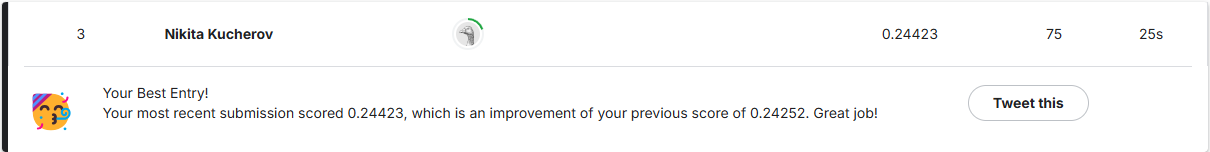

In [71]:
# TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
# TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"
TRAIN = 'data\chocolate-rating\chocolate_train.csv'
TEST = 'data\chocolate-rating\chocolate_test_new.csv'

In [72]:
train_df = pd.read_csv(TRAIN)

In [73]:
test_df = pd.read_csv(TEST)

In [74]:
train_df['Bean Type'].value_counts().index[0]

'\xa0'

In [75]:
train_df = train_df.replace('\xa0', np.NaN)
test_df = test_df.replace('\xa0', np.NaN)

# Обзор данных

Описание данных
* Company - компания производитель
* Specific Bean Origin - географический регион происхождения
* REF - параметр, определяющий момент внесения записи в базу данных (чем выше значение, тем "свежее" запись)
* Review - дата публикации отзыва
* Cocoa Percent - процентное содержание какао
* Company Location - страна производитель
* Rating - экспертный рейтинг
* Bean Type - используемый сорт какао-бобов, если таковой имеется
* Broad Bean Origin - географический регион происхождения какао-бобов

In [76]:
test_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Ohiyo,"San Juan Estate, Gran Couva",1594,2015,70%,U.S.A.,Trinitario,Trinidad
1,Blanxart,Organic Dark,322,2009,72%,Spain,NaN,NaN
2,Brazen,Maya Mountain,1518,2015,80%,U.S.A.,Trinitario,Belize
3,Patric,Madagascar,439,2009,67%,U.S.A.,Trinitario,Madagascar
4,Potomac,"Upala, Batch 12",607,2010,82%,U.S.A.,Matina,Costa Rica


In [77]:
test_df.nunique()

Company                 244
Specific Bean Origin    385
REF                     338
Review                   12
Cocoa Percent            38
Company Location         42
Bean Type                19
Broad Bean Origin        59
dtype: int64

In [78]:
test_df.nunique()

Company                 244
Specific Bean Origin    385
REF                     338
Review                   12
Cocoa Percent            38
Company Location         42
Bean Type                19
Broad Bean Origin        59
dtype: int64

In [79]:
# Словарь маппинга для разновидностей какао сорта
cacao_map = {
    'Amazonian': ['Amazon', 'Amazon mix', 'Amazon, ICS'],
    'Beniano': ['Beniano'],
    'Blend': ['Blend', 'Blend-Forastero,Criollo', 'Criollo, Forastero', 'Criollo, Trinitario',
    'Forastero, Trinitario', 'Trinitario, Criollo', 'Trinitario, Forastero', 'Trinitario, Nacional',
    'Trinitario, TCGA'],
    'CCN51': ['CCN51'],
    'Criollo': ['Criollo', 'Criollo (Amarru)', 'Criollo (Ocumare 61)', 'Criollo (Ocumare 67)',
    'Criollo (Ocumare 77)', 'Criollo (Ocumare)', 'Criollo (Porcelana)', 'Criollo (Wild)',
    'Criollo, +'],
    'EET': ['EET'],
    'Forastero': ['Forastero', 'Forastero (Amelonado)', 'Forastero (Arriba)', 'Forastero (Arriba) ASS',
    'Forastero (Arriba) ASSS', 'Forastero (Catongo)', 'Forastero (Nacional)', 'Forastero (Parazinho)',
    'Forastero(Arriba, CCN)'],
    'Matina': ['Matina'],
    'Nacional': ['Nacional', 'Nacional (Arriba)'],
    'Trinitario': ['Trinitario', 'Trinitario (85% Criollo)', 'Trinitario (Amelonado)', 'Trinitario (Scavina)']
}

# Функция для маппинга типов какао
def map_cacao_type(value):
    for category, variants in cacao_map.items():
        if value in variants:
            return category
    return value

In [80]:
train_df['Bean Type'] = train_df['Bean Type'].apply(map_cacao_type)
test_df['Bean Type'] = test_df['Bean Type'].apply(map_cacao_type)

In [81]:
# Словарь соответствий (дочерние -> основное). Названия регионов
region_mapping = {'Australia': ['Australia'],
 'Belize': ['Belize'],
 'Bolivia': ['Bolivia'],
 'Brazil': ['Brazil'],
 'Burma': ['Burma'],
 'Cameroon': ['Cameroon'],
 'Carribean': ['Carribean', 'Carribean(DR/Jam/Tri)', 'Africa, Carribean, C. Am.'],
 'Colombia': ['Colombia', 'Colombia, Ecuador'],
 'Congo': ['Congo'],
 'Costa Rica': ['Costa Rica', 'Cost Rica, Ven'],
 'Cuba': ['Cuba'],
 'Dominican Republic': ['Dominican Republic', 'DR, Ecuador, Peru', 'Dom. Rep., Madagascar', 'Domincan Republic', 'Dominican Rep., Bali'],
 'Ecuador': ['Ecuador', 'Ecuador, Costa Rica', 'Ecuador, Mad., PNG'],
 'El Salvador': ['El Salvador'],
 'Fiji': ['Fiji'],
 'Gabon': ['Gabon'],
 'Ghana': ['Ghana', 'Ghana & Madagascar', 'Ghana, Domin. Rep', 'Ghana, Panama, Ecuador'],
 'Grenada': ['Grenada', 'Gre., PNG, Haw., Haiti, Mad'],
 'Guatemala': ['Guatemala', 'Guat., D.R., Peru, Mad., PNG',],
 'Haiti': ['Haiti'],
 'Hawaii': ['Hawaii'],
 'Honduras': ['Honduras'],
 'India': ['India'],
 'Indonesia': ['Indonesia', 'Indonesia, Ghana'],
 'Ivory Coast': ['Ivory Coast'],
 'Jamaica': ['Jamaica'],
 'Liberia': ['Liberia'],
 'Madagascar': ['Madagascar', 'Madagascar & Ecuador','Mad., Java, PNG'],
 'Malaysia': ['Malaysia'],
 'Martinique': ['Martinique'],
 'Mexico': ['Mexico'],
 'Nicaragua': ['Nicaragua'],
 'Nigeria': ['Nigeria'],
 'Panama': ['Panama'],
 'Papua New Guinea': ['Papua New Guinea', 'PNG, Vanuatu, Mad'],
 'Peru': ['Peru', 'Peru(SMartin,Pangoa,nacional)', 'Peru, Belize', 'Peru, Dom. Rep', 'Peru, Ecuador',
 'Peru, Ecuador, Venezuela', 'Peru, Mad., Dom. Rep.', 'Peru, Madagascar'],
 'Philippines': ['Philippines'],
 'Principe': ['Principe'],
 'Puerto Rico': ['Puerto Rico'],
 'Samoa': ['Samoa'],
 'Sao Tome': ['Sao Tome', 'Sao Tome & Principe'],
 'Solomon Islands': ['Solomon Islands'],
 'South America': ['South America', 'South America, Africa', 'Central and S. America'],
 'Sri Lanka': ['Sri Lanka'],
 'St. Lucia': ['St. Lucia'],
 'Suriname': ['Suriname'],
 'Tanzania': ['Tanzania'],
 'Tobago': ['Tobago'],
 'Togo': ['Togo'],
 'Trinidad': ['Trinidad', 'Trinidad, Ecuador', 'Trinidad, Tobago', 'Trinidad-Tobago',],
 'Uganda': ['Uganda'],
 'Vanuatu': ['Vanuatu'],
'Venezuela': ['Venezuela', 'Ven, Bolivia, D.R.', 'Ven, Trinidad, Ecuador', 'Ven., Indonesia, Ecuad.',
 'Ven., Trinidad, Mad.', 'Ven.,Ecu.,Peru,Nic.', 'Venez,Africa,Brasil,Peru,Mex',
 'Venezuela, Carribean', 'Venezuela, Dom. Rep.', 'Venezuela, Ghana', 'Venezuela, Java',
 'Venezuela, Trinidad', 'Venezuela/ Ghana'],
 'Vietnam': ['Vietnam'],
 'West Africa': ['West Africa']
}

# Функция для замены названий
def standardize_region(region):
    for main_region, aliases in region_mapping.items():
        if region in aliases:
            return main_region
    return region # Если нет в словаре, оставить как есть


In [82]:
train_df['Broad Bean Origin'] = train_df['Broad Bean Origin'].apply(standardize_region)
test_df['Broad Bean Origin'] = test_df['Broad Bean Origin'].apply(standardize_region)

In [83]:
df_concat = pd.concat([train_df, test_df], axis=0)

In [84]:
cols_temp = ['Company', 'Specific Bean Origin',
       'Company Location', 'Bean Type', 'Broad Bean Origin']

In [85]:
cols_temp

['Company',
 'Specific Bean Origin',
 'Company Location',
 'Bean Type',
 'Broad Bean Origin']

In [86]:
df_concat

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,NaN,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,NaN,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia
...,...,...,...,...,...,...,...,...,...
535,Monsieur Truffe,Papaua New Guinea,1391,2014,70%,Australia,NaN,NaN,Papua New Guinea
536,Cacao Hunters,Macondo,1816,2016,71%,Colombia,NaN,NaN,Colombia
537,Bonnat,Maragnam,1038,2013,75%,France,NaN,NaN,Brazil
538,Altus aka Cao Artisan,Acopagro,1728,2016,60%,U.S.A.,NaN,NaN,Peru


In [87]:
from association_metrics import CramersV

cramer_df = df_concat[cols_temp]
cramer_df = cramer_df.astype('category')

cramer = CramersV(cramer_df)
cramer = cramer.fit()

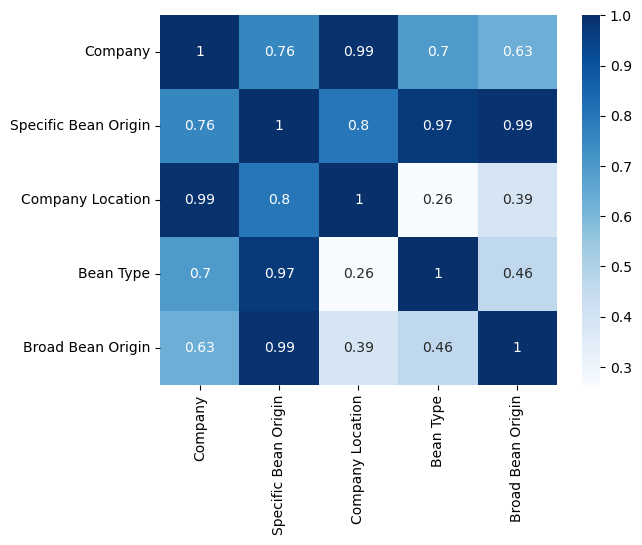

In [88]:
import seaborn as sns

sns.heatmap(cramer, cmap='Blues', annot=True);

In [89]:
def select_top3_corr_cols(col_in):
    select_df = cramer[col_in].sort_values(ascending=False)
    return select_df[1:].index.to_list()

In [90]:
def get_temp_df(col_in, col_on, SEED):
    np.random.seed(SEED)
    temp_df = df_concat.groupby(col_on)[col_in] \
                        .agg(lambda x: np.random.choice(x.mode()) if len(x.mode()) > 0 else np.NaN) \
                        .dropna().reset_index()
    return temp_df

In [91]:
def fill_rows(row, col_on, temp_df):
    for variants, category in temp_df.values:
        if row[col_on] == variants:
            return category
    return np.NaN

In [92]:
train_df.isna().sum()

Company                   0
Specific Bean Origin      0
REF                       0
Review                    0
Cocoa Percent             0
Company Location          0
Rating                    0
Bean Type               629
Broad Bean Origin        56
dtype: int64

In [93]:
def prepared_df(df, col_in, SEED):

    selected_cols = select_top3_corr_cols(col_in)
    print(selected_cols)
    for col_on in selected_cols:
        temp_df = get_temp_df(col_in, col_on, SEED)
        df[col_in] = df.apply(lambda row: fill_rows(row, col_on, temp_df) if row[col_in] is np.NaN else row[col_in], axis=1)
        df[col_in] = df[col_in].fillna('Other')

In [94]:
cols_in = ['Bean Type', 'Broad Bean Origin']

SEED = 4784
print(SEED)

for col_in in cols_in:
    prepared_df(train_df, col_in, SEED)

for col_in in cols_in:
    prepared_df(test_df, col_in, SEED)

4784
['Specific Bean Origin', 'Company', 'Broad Bean Origin', 'Company Location']
['Specific Bean Origin', 'Company', 'Bean Type', 'Company Location']
['Specific Bean Origin', 'Company', 'Broad Bean Origin', 'Company Location']
['Specific Bean Origin', 'Company', 'Bean Type', 'Company Location']


In [95]:
train_df.isna().sum()

Company                 0
Specific Bean Origin    0
REF                     0
Review                  0
Cocoa Percent           0
Company Location        0
Rating                  0
Bean Type               0
Broad Bean Origin       0
dtype: int64

In [96]:
train_df = train_df.replace('\xa0', np.NaN)
train_df['Cocoa Percent'] = train_df['Cocoa Percent'].str.rstrip('%').astype(np.float16)
train_df['Review'] = train_df['Review'].astype('object')

test_df = test_df.replace('\xa0', np.NaN)
test_df['Cocoa Percent'] = test_df['Cocoa Percent'].str.rstrip('%').astype(np.float16)
test_df['Review'] = test_df['Review'].astype('object')

In [97]:
train_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72.0,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72.0,Switzerland,3.50,Other,Venezuela
2,Dark Forest,Tanzania,1554,2015,70.0,U.S.A.,3.00,Criollo,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72.0,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75.0,France,3.50,Criollo,Indonesia


In [98]:
train_df.dtypes

Company                  object
Specific Bean Origin     object
REF                       int64
Review                   object
Cocoa Percent           float16
Company Location         object
Rating                  float64
Bean Type                object
Broad Bean Origin        object
dtype: object

In [99]:
['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin']

cols = ['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
'Company Location', 'Bean Type', 'Broad Bean Origin']

In [100]:
X = train_df[cols]
target = train_df['Rating']
test = test_df[cols]

In [101]:
mm_scaler = MinMaxScaler()
scaler = StandardScaler()

X['REF'] = mm_scaler.fit_transform(X[['REF']])  
test['REF'] = mm_scaler.transform(test[['REF']])

In [102]:
mm_scaler = MinMaxScaler()

X['Cocoa Percent'] = mm_scaler.fit_transform(X[['Cocoa Percent']])  
test['Cocoa Percent'] = mm_scaler.transform(test[['Cocoa Percent']])

In [103]:
X

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,0.232152,2009,0.481934,U.K.,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",0.258346,2010,0.481934,Switzerland,Other,Venezuela
2,Dark Forest,Tanzania,0.795583,2015,0.444824,U.S.A.,Criollo,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,0.575244,2013,0.481934,U.S.A.,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",0.013867,2006,0.537598,France,Criollo,Indonesia
...,...,...,...,...,...,...,...,...
1250,Artisan du Chocolat,Madagascar,0.183873,2009,0.630371,U.K.,Blend,Madagascar
1251,Marana,Cusco,0.965074,2016,0.444824,Peru,Other,Peru
1252,Arete,Nacional,0.785311,2015,0.407715,U.S.A.,Forastero,Peru
1253,Fresco,"Conacado, #212, LR, SC",0.327170,2011,0.481934,U.S.A.,Other,Dominican Republic


In [104]:
X.dtypes

Company                  object
Specific Bean Origin     object
REF                     float64
Review                   object
Cocoa Percent           float16
Company Location         object
Bean Type                object
Broad Bean Origin        object
dtype: object

In [105]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

## Обучение и подбор гиперпараметров

In [106]:
def objective_catboost(trial):

    params = {
        'max_depth': 4,
        'learning_rate': trial.suggest_float("learning_rate", 0.0005, 0.2, log=True),    # Скорость обучения
        'n_estimators': trial.suggest_int("n_estimators", 1800, 3000),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),   # Коэффициент L2-регуляризации
        'random_strength': trial.suggest_float("random_strength", 0, 10),   # Степень случайности
        'bagging_temperature':  trial.suggest_float("bagging_temperature", 0, 1),   # Интенсивность бэггинга
        # 'grow_policy': 'SymmetricTree',
        'border_count': trial.suggest_int("border_count", 32, 255),
        # 'iterations': trial.suggest_int('iterations', 100, 300),  # Количество итераций
        # 'depth': trial.suggest_int('depth', 3, 4, 5),  # Глубина деревьев
        # 'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Скорость обучения
        # 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),  # Коэффициент L2-регуляризации
        # 'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),  # Функция потерь
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 20),  # Ранняя остановка
        # 'border_count': trial.suggest_categorical('border_count', [32, 128]),  # Количество границ
        # 'random_strength': trial.suggest_float('random_strength', 0.1, 10),  # Степень случайности
        # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Интенсивность бэггинга
        # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),    # Стратегия роста
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 15),   # Минимальное количество объектов в листе
        # 'rsm': trial.suggest_float('rsm', 0.8, 1.0),    # Доля признаков для каждого дерева

    }
    
    model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

    score = cross_val_score(model, X, target, cv=3, scoring="r2", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=1500, n_jobs=-1)

[I 2025-05-17 14:25:31,352] A new study created in memory with name: no-name-db856c82-3d1e-4dfb-9c0e-ee7ced6e1a8b
[I 2025-05-17 14:25:58,411] Trial 1 finished with value: 0.19280036806297618 and parameters: {'learning_rate': 0.04881132438894993, 'n_estimators': 1802, 'l2_leaf_reg': 3.641993712454484, 'random_strength': 8.504418020905732, 'bagging_temperature': 0.5855387685251772, 'border_count': 160, 'min_data_in_leaf': 11}. Best is trial 1 with value: 0.19280036806297618.
[I 2025-05-17 14:26:04,389] Trial 2 finished with value: 0.12822835021855547 and parameters: {'learning_rate': 0.0016720464229630914, 'n_estimators': 2504, 'l2_leaf_reg': 8.998256538118943, 'random_strength': 6.567583401567139, 'bagging_temperature': 0.5554906276660869, 'border_count': 43, 'min_data_in_leaf': 6}. Best is trial 1 with value: 0.19280036806297618.
[I 2025-05-17 14:26:51,008] Trial 3 finished with value: 0.1788525623857193 and parameters: {'learning_rate': 0.0036869110202438805, 'n_estimators': 2214, 'l2

In [107]:
print(study.best_params)

{'learning_rate': 0.010106827616444608, 'n_estimators': 2152, 'l2_leaf_reg': 1.2939524297889973, 'random_strength': 5.601488725267312, 'bagging_temperature': 0.7579931149848919, 'border_count': 156, 'min_data_in_leaf': 13}


In [108]:
# [I 2025-05-12 15:22:30,361] Trial 156 finished with value: 0.21593551418797222 and parameters: 
# {'learning_rate': 0.010085724934530157, 
#'n_estimators': 2063, 
#'l2_leaf_reg': 1.006603127309495, 
#'random_strength': 1.4219666225791285, 
#'bagging_temperature': 0.47554294906158245}. 
# Best is trial 156 with value: 0.21593551418797222.

params = study.best_params
# params = {'learning_rate': 0.008553940111605946, 'n_estimators': 2114, 'l2_leaf_reg': 1.4163130536678312, 'random_strength': 4.287920281067569, 'bagging_temperature': 0.7916641053388684, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'rsm': 0.9923008576207031}
model = CatBoostRegressor(
        cat_features=cat_features, **params,
        silent=True
    )
model.fit(X, target)

In [109]:
pred = model.predict(test)

In [110]:
test = test.copy()
result = pd.DataFrame()
result['id'] = np.arange(len(test))
result['Rating'] = pred

result[['id','Rating']].to_csv("choko_submission_66.csv", index=False)

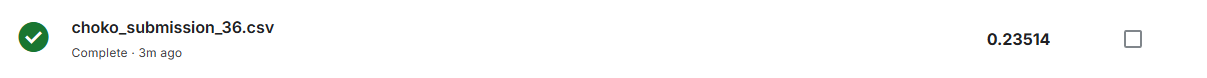

<!-- {'learning_rate': 0.008553940111605946, 'n_estimators': 2114, 'l2_leaf_reg': 1.4163130536678312, 'random_strength': 4.287920281067569, 'bagging_temperature': 0.7916641053388684, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'rsm': 0.9923008576207031} -->

In [111]:
# {'learning_rate': 0.008553940111605946, 'n_estimators': 2114, 'l2_leaf_reg': 1.4163130536678312, 'random_strength': 4.287920281067569, 'bagging_temperature': 0.7916641053388684, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'rsm': 0.9923008576207031}

In [112]:
875
0.9676140981916675
0.028993107695535775

0.028993107695535775

In [113]:
y_test = pd.read_csv('choko_submission_29.csv', usecols=['Rating']).values.reshape(-1)

print(SEED)
r2 = r2_score(y_test, pred)
print(r2)
mae = MAE(y_test, pred)
print(mae)

4784
0.950144912900406
0.03715478515882205


# Загрузка данных

In [114]:
# TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
# TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"
TRAIN = 'data\chocolate-rating\chocolate_train.csv'
TEST = 'data\chocolate-rating\chocolate_test_new.csv'

In [115]:
train_df = pd.read_csv(TRAIN)

In [116]:
test_df = pd.read_csv(TEST)

In [117]:
train_df['Bean Type'].value_counts().index[0]

'\xa0'

In [118]:
train_df = train_df.replace('\xa0', np.NaN)
test_df = test_df.replace('\xa0', np.NaN)

In [119]:
df_concat = pd.concat([train_df, test_df], axis=0)
df_concat.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,NaN,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,NaN,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


In [120]:
# pd.DataFrame(df_concat['Bean Type'].value_counts()).sort_values('Bean Type')

In [121]:
# sorted(map(str, df_concat['Bean Type'].unique()))

In [122]:
# # Словарь маппинга для разновидностей какао сорта
# cacao_map = {
#     'Amazonian': ['Amazon', 'Amazon mix', 'Amazon, ICS'],
#     'Beniano': ['Beniano'],
#     'Blend': ['Blend', 'Blend-Forastero,Criollo', 'Criollo, Forastero', 'Criollo, Trinitario',
#     'Forastero, Trinitario', 'Trinitario, Criollo', 'Trinitario, Forastero', 'Trinitario, Nacional',
#     'Trinitario, TCGA'],
#     'CCN51': ['CCN51'],
#     'Criollo': ['Criollo', 'Criollo (Amarru)', 'Criollo (Ocumare 61)', 'Criollo (Ocumare 67)',
#     'Criollo (Ocumare 77)', 'Criollo (Ocumare)', 'Criollo (Porcelana)', 'Criollo (Wild)',
#     'Criollo, +'],
#     'EET': ['EET'],
#     'Forastero': ['Forastero', 'Forastero (Amelonado)', 'Forastero (Arriba)', 'Forastero (Arriba) ASS',
#     'Forastero (Arriba) ASSS', 'Forastero (Catongo)', 'Forastero (Nacional)', 'Forastero (Parazinho)',
#     'Forastero(Arriba, CCN)'],
#     'Matina': ['Matina'],
#     'Nacional': ['Nacional', 'Nacional (Arriba)'],
#     'Trinitario': ['Trinitario', 'Trinitario (85% Criollo)', 'Trinitario (Amelonado)', 'Trinitario (Scavina)']
# }

# {    'Criollo': ['Criollo', 'Criollo (Porcelana)', 'Criollo (Amarru)', 'Criollo (Ocumare 77)', 'Criollo (Ocumare 67)',
#     'Criollo (Ocumare 61)', 'Criollo (Ocumare)', 'Criollo (Wild)', 'Criollo, +'],
#     'Trinitario': ['Trinitario', 'Trinitario (Amelonado)', 'Trinitario, TCGA', 'Trinitario (85% Criollo)'],
#     'Forastero': ['Forastero', 'Forastero (Arriba)', 'Forastero (Arriba) ASS', 'Forastero (Arriba) ASSS',
#     'Forastero (Nacional)', 'Forastero (Parazinho)', 'Forastero (Catongo)', 'Forastero (Amelonado)'],
#     'Nacional': ['Nacional', 'Nacional (Arriba)'],
#     'Amazonian': ['Amazon', 'Amazon mix', 'Amazon, ICS'],
#     'Blend': ['Criollo, Trinitario', 'Trinitario, Criollo', 'Trinitario, Forastero', 'Forastero, Trinitario',
#     'Trinitario, Nacional', 'Criollo, Forastero', 'Blend-Forastero,Criollo', 'Blend']
# }

In [123]:
# pd.set_option('display.max_rows', 100)
# pd.DataFrame(df_concat['Broad Bean Origin'].value_counts()).sort_values('Broad Bean Origin')

In [124]:
# res = df_concat.groupby('Broad Bean Origin').agg({'Rating': 'mean'})
# plt.figure(figsize=(15,5))
# sns.barplot(data = res, x='Broad Bean Origin', y='Rating', palette='summer')
# plt.xticks(rotation=90)
# plt.show()

In [125]:
# sorted(map(str, df_concat['Broad Bean Origin'].unique()))

In [126]:
# # Словарь соответствий (дочерние -> основное). Названия регионов
# region_mapping = {'Australia': ['Australia'],
#  'Belize': ['Belize'],
#  'Bolivia': ['Bolivia'],
#  'Brazil': ['Brazil'],
#  'Burma': ['Burma'],
#  'Cameroon': ['Cameroon'],
#  'Carribean': ['Carribean', 'Carribean(DR/Jam/Tri)', 'Africa, Carribean, C. Am.'],
#  'Colombia': ['Colombia', 'Colombia, Ecuador'],
#  'Congo': ['Congo'],
#  'Costa Rica': ['Costa Rica', 'Cost Rica, Ven'],
#  'Cuba': ['Cuba'],
#  'Dominican Republic': ['Dominican Republic', 'DR, Ecuador, Peru', 'Dom. Rep., Madagascar', 'Domincan Republic', 'Dominican Rep., Bali'],
#  'Ecuador': ['Ecuador', 'Ecuador, Costa Rica', 'Ecuador, Mad., PNG'],
#  'El Salvador': ['El Salvador'],
#  'Fiji': ['Fiji'],
#  'Gabon': ['Gabon'],
#  'Ghana': ['Ghana', 'Ghana & Madagascar', 'Ghana, Domin. Rep', 'Ghana, Panama, Ecuador'],
#  'Grenada': ['Grenada', 'Gre., PNG, Haw., Haiti, Mad'],
#  'Guatemala': ['Guatemala', 'Guat., D.R., Peru, Mad., PNG',],
#  'Haiti': ['Haiti'],
#  'Hawaii': ['Hawaii'],
#  'Honduras': ['Honduras'],
#  'India': ['India'],
#  'Indonesia': ['Indonesia', 'Indonesia, Ghana'],
#  'Ivory Coast': ['Ivory Coast'],
#  'Jamaica': ['Jamaica'],
#  'Liberia': ['Liberia'],
#  'Madagascar': ['Madagascar', 'Madagascar & Ecuador','Mad., Java, PNG'],
#  'Malaysia': ['Malaysia'],
#  'Martinique': ['Martinique'],
#  'Mexico': ['Mexico'],
#  'Nicaragua': ['Nicaragua'],
#  'Nigeria': ['Nigeria'],
#  'Panama': ['Panama'],
#  'Papua New Guinea': ['Papua New Guinea', 'PNG, Vanuatu, Mad'],
#  'Peru': ['Peru', 'Peru(SMartin,Pangoa,nacional)', 'Peru, Belize', 'Peru, Dom. Rep', 'Peru, Ecuador',
#  'Peru, Ecuador, Venezuela', 'Peru, Mad., Dom. Rep.', 'Peru, Madagascar'],
#  'Philippines': ['Philippines'],
#  'Principe': ['Principe'],
#  'Puerto Rico': ['Puerto Rico'],
#  'Samoa': ['Samoa'],
#  'Sao Tome': ['Sao Tome', 'Sao Tome & Principe'],
#  'Solomon Islands': ['Solomon Islands'],
#  'South America': ['South America', 'South America, Africa', 'Central and S. America'],
#  'Sri Lanka': ['Sri Lanka'],
#  'St. Lucia': ['St. Lucia'],
#  'Suriname': ['Suriname'],
#  'Tanzania': ['Tanzania'],
#  'Tobago': ['Tobago'],
#  'Togo': ['Togo'],
#  'Trinidad': ['Trinidad', 'Trinidad, Ecuador', 'Trinidad, Tobago', 'Trinidad-Tobago',],
#  'Uganda': ['Uganda'],
#  'Vanuatu': ['Vanuatu'],
# 'Venezuela': ['Venezuela', 'Ven, Bolivia, D.R.', 'Ven, Trinidad, Ecuador', 'Ven., Indonesia, Ecuad.',
#  'Ven., Trinidad, Mad.', 'Ven.,Ecu.,Peru,Nic.', 'Venez,Africa,Brasil,Peru,Mex',
#  'Venezuela, Carribean', 'Venezuela, Dom. Rep.', 'Venezuela, Ghana', 'Venezuela, Java',
#  'Venezuela, Trinidad', 'Venezuela/ Ghana'],
#  'Vietnam': ['Vietnam'],
#  'West Africa': ['West Africa']
# }

# # Функция для замены названий
# def standardize_region(region):
#     for main_region, aliases in region_mapping.items():
#         if region in aliases:
#             return main_region
#     return region # Если нет в словаре, оставить как есть



# {
#     'Venezuela': ['Ven.', 'Ven', 'Venez', 'Venezuela/ Ghana', ],
#     'Dominican Republic': ['Domincan Republic', 'Dom. Rep', 'D.R.', 'Domin. Rep', 'Dom. Rep.', 'Dominican Rep.', 'DR'],
#     'Costa Rica': ['Cost Rica'],
#     'Ecuador': ['Ecuad.', 'Ecu.'],
#     'Nicaragua': ['Nic.'],
#     'Madagascar': ['Mad.', 'Mad'],
#     'Brazil': ['Brasil'],
#     'Mexico': ['Mex'],
#     'Guatemala': ['Guat.'],
#     'Sao Tome & Principe': ['Sao Tome', 'Principe'],
#     'Papua New Guinea': ['PNG'],
#     'Carribean': ['Carribean(DR/Jam/Tri)'],
#     'Indonesia': ['Java', 'Bali'],
#     'West Africa': ['Africa'],
#     'Trinidad': ['Trinidad-Tobago', 'Trinidad']
# }


In [127]:
y_res_1 = pd.read_csv('choko_submission_65.csv', usecols=['Rating'])
y_res_2 = pd.read_csv('choko_submission_66.csv', usecols=['Rating'])

In [128]:
y_res_3 = np.mean([y_res_1['Rating'].values, y_res_2['Rating'].values], axis=0)
y_res_3

array([3.19971894, 3.05194139, 3.05501028, 3.60904455, 3.08922623,
       2.64125523, 3.09449288, 3.24528156, 3.19966421, 2.77800962,
       3.47166838, 3.06509409, 3.09329933, 3.23357079, 2.61166672,
       3.36380826, 3.28241806, 3.44103946, 3.11043788, 3.24818994,
       2.98623952, 3.12995877, 3.16334507, 3.05026486, 3.45516312,
       3.46603387, 3.14304971, 3.1326044 , 3.17409466, 2.91994525,
       3.36350427, 2.64176363, 3.00861646, 3.02428786, 2.99858488,
       3.33824059, 3.466402  , 2.87649216, 3.18744754, 3.11154991,
       2.95221145, 3.37587148, 3.36744989, 3.41844828, 3.21523663,
       3.52146203, 3.39889688, 3.47091422, 2.99582449, 3.27826829,
       2.83124115, 3.11129255, 3.42475432, 3.30135656, 3.35821999,
       2.80743462, 3.39413553, 3.00245106, 3.38104673, 3.17101704,
       3.16097426, 3.38184572, 3.10113658, 3.23722922, 3.30503218,
       2.72347512, 2.86703458, 3.44818171, 3.37749948, 3.4435904 ,
       3.1311583 , 3.27225009, 3.34365467, 3.62735303, 3.18962

In [129]:
# TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
# TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"
TRAIN = 'data\chocolate-rating\chocolate_train.csv'
TEST = 'data\chocolate-rating\chocolate_test_new.csv'

In [130]:
test = pd.read_csv(TEST)

In [131]:
test = test.copy()
result = pd.DataFrame()
result['id'] = np.arange(len(test))
result['Rating'] = y_res_3

result[['id','Rating']].to_csv("choko_submission_65_66.csv", index=False)

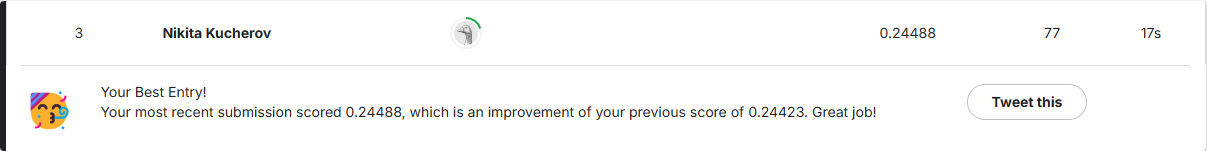

In [132]:
y_res_1 = pd.read_csv('choko_submission_65.csv', usecols=['Rating'])
y_res_2 = pd.read_csv('choko_submission_32.csv', usecols=['Rating'])

In [133]:
y_res_3 = np.mean([y_res_1['Rating'].values, y_res_2['Rating'].values], axis=0)
y_res_3

array([3.19286675, 3.0497561 , 3.05837299, 3.57882469, 3.09152344,
       2.65715642, 3.09633675, 3.22270815, 3.21914715, 2.73896291,
       3.45597938, 3.04970705, 3.11514392, 3.1993373 , 2.63377616,
       3.36018362, 3.27691367, 3.42818563, 3.0937436 , 3.24736025,
       2.99194572, 3.11996919, 3.15129617, 3.05274491, 3.45670833,
       3.45394925, 3.12729479, 3.14071767, 3.16757648, 2.91898486,
       3.34125701, 2.7239236 , 2.99468531, 3.01201421, 2.97811614,
       3.35403494, 3.45007882, 2.89646006, 3.19302876, 3.11014205,
       2.9470363 , 3.35986145, 3.33638299, 3.41326841, 3.20064729,
       3.50844741, 3.39803402, 3.47020692, 3.01695956, 3.26366274,
       2.83001358, 3.09040966, 3.43057136, 3.29753625, 3.3560325 ,
       2.78803031, 3.40982691, 3.01037087, 3.35333844, 3.19127312,
       3.14056106, 3.3778858 , 3.12138994, 3.24347766, 3.2933117 ,
       2.72984796, 2.8660976 , 3.45117726, 3.3829393 , 3.44722541,
       3.11830561, 3.28127889, 3.33625109, 3.60657528, 3.20940

In [134]:
# TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
# TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"
TRAIN = 'data\chocolate-rating\chocolate_train.csv'
TEST = 'data\chocolate-rating\chocolate_test_new.csv'

In [135]:
test = pd.read_csv(TEST)

In [136]:
test = test.copy()
result = pd.DataFrame()
result['id'] = np.arange(len(test))
result['Rating'] = y_res_3

result[['id','Rating']].to_csv("choko_submission_65_32.csv", index=False)

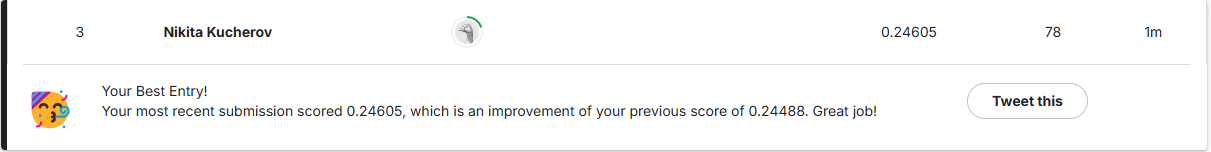

In [137]:
y_res_1 = pd.read_csv('choko_submission_35.csv', usecols=['Rating'])
y_res_2 = pd.read_csv('choko_submission_66.csv', usecols=['Rating'])

In [138]:
y_res_3 = np.mean([y_res_1['Rating'].values, y_res_2['Rating'].values], axis=0)
y_res_3

array([3.19931187, 3.04686296, 3.04738438, 3.6110211 , 3.07123164,
       2.68244724, 3.09230536, 3.23701661, 3.20810497, 2.75630069,
       3.48283317, 3.08150737, 3.04819128, 3.22809176, 2.58800315,
       3.37319738, 3.2860758 , 3.44074714, 3.11621823, 3.23638889,
       3.000285  , 3.13604831, 3.17414812, 3.05042969, 3.43680904,
       3.46962924, 3.16008186, 3.13680434, 3.15326532, 2.91235545,
       3.39017713, 2.60588818, 2.99852841, 3.0193642 , 2.99358833,
       3.34881162, 3.47403685, 2.90170809, 3.20139301, 3.11755524,
       2.96408561, 3.37981005, 3.37829816, 3.41511837, 3.1994469 ,
       3.51942711, 3.40278734, 3.47160644, 3.00963376, 3.27899512,
       2.83465387, 3.11308223, 3.42325786, 3.29938314, 3.35300286,
       2.80404901, 3.41592096, 2.99355753, 3.3878161 , 3.1766829 ,
       3.15605046, 3.39652588, 3.09015758, 3.2320598 , 3.29563992,
       2.7200688 , 2.85118946, 3.44264958, 3.38243725, 3.46267245,
       3.11538166, 3.2653657 , 3.33384699, 3.63198837, 3.21123

In [139]:
# TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
# TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"
TRAIN = 'data\chocolate-rating\chocolate_train.csv'
TEST = 'data\chocolate-rating\chocolate_test_new.csv'

In [140]:
test = pd.read_csv(TEST)

In [141]:
test = test.copy()
result = pd.DataFrame()
result['id'] = np.arange(len(test))
result['Rating'] = y_res_3

result[['id','Rating']].to_csv("choko_submission_35_66.csv", index=False)